# **GloVe: Global Vectors for Word Representation - Word Embeddings -  Stanford**

- [Web Official - GloVe ](https://nlp.stanford.edu/projects/glove/)
- [Download Pre-trained word vectors](https://nlp.stanford.edu/data/glove.6B.zip)
    - 6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download
- [GloVe: Global Vectors for Word Representation - Citing GloVe](https://nlp.stanford.edu/pubs/glove.pdf)

**Introduction**

**GloVe** is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

## **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.cm import get_cmap
from numpy.linalg import norm
from adjustText import adjust_text
from scipy.spatial import ConvexHull

plt.style.use('fivethirtyeight')

In [2]:
PATH = "glove.6B.300d.txt"
emb_dim = 300

## **Functions**



In [3]:
# Loads and processes an embeddings file (e.g., GloVe) into a convenient dictionary.
def create_embeddings_dictionary(path):
    """
    Reads an embeddings file (e.g., in GloVe format) and creates a dictionary mapping words to their embedding vectors.
    
    Parameters:
        path (str): The file path to the embeddings file.
        
    Returns:
        dict: A dictionary where each key is a word (str) and each value is a numpy array of floats representing the embedding.
    """
    embeddings_dict = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            # Split the line into its components: the first token is the word,
            # and the remaining tokens are the embedding vector components.
            values = line.strip().split()
            word = values[0]
            # Convert the remaining values into a numpy array of floats.
            vector = np.array(values[1:], dtype=float)
            embeddings_dict[word] = vector
    return embeddings_dict


# Displays the first n lines of a text file for quick inspection.
def show_n_first_words(path, n_words=10):
    """
    Reads a text file line by line and prints each line (with whitespace removed)
    along with the length of the line's substring starting from the second character.
    
    Parameters:
        path (str): The file path of the text file.
        n_words (int): The number of lines to display (default is 10).
    
    Returns:
        None
    """
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            # Remove any leading and trailing whitespace from the line.
            stripped_line = line.strip()
            # Calculate the length of the line, excluding the first character.
            # (Note: This might be used to check the length of the vector part in a GloVe-like file.)
            length_excluding_first = len(stripped_line[1:])
            print(stripped_line, length_excluding_first)
            
            # Stop after printing n_words lines.
            if i >= n_words:
                break


# Projects word embeddings to 2D (via PCA or t-SNE) and visualizes them grouped by category.
def plot_embeddings_by_category(embeddings_dict, categories_dict, emb_dim=300, 
                                reducer=PCA, random_state=42, figsize=(15,10)):
    """
    Plots word embeddings projected into 2D using a dimensionality reduction technique
    (e.g., PCA or t-SNE) and groups them by category. Each category is assigned a unique color,
    and a convex hull (with a light fill) is drawn around points from the same category. 
    Text annotations are adjusted to minimize overlaps.
    
    Parameters:
        embeddings_dict (dict): A dictionary where keys are words (str) and values are their 
                                corresponding embedding vectors (numpy arrays).
        categories_dict (dict): A dictionary with keys as category names (str) and values as lists 
                                of words in that category.
                                e.g., {'animals': ['dog', 'cat'], 'vehicles': ['car', 'truck'], ...}
        emb_dim (int): The dimensionality of the embedding vectors (default 300).
        reducer (class): The dimensionality reduction class from sklearn (e.g., PCA or TSNE).
        random_state (int): Seed for reproducibility.
        figsize (tuple): Figure size for the plot (default (15,10)).
    
    Returns:
        None. Displays a matplotlib plot.
    """
    
    # 1. Prepare a combined list of words and corresponding category labels
    all_categories = list(categories_dict.keys())
    all_words = []
    cat_labels = []
    
    for cat in all_categories:
        for w in categories_dict[cat]:
            if w in embeddings_dict:
                all_words.append(w)
                cat_labels.append(cat)
            else:
                print(f"Word '{w}' not found in embeddings_dict. Ignoring.")
    
    # 2. Create an embedding matrix (n_words x emb_dim)
    X = np.zeros((len(all_words), emb_dim))
    for i, w in enumerate(all_words):
        X[i] = embeddings_dict[w]
    
    # 3. Reduce the embeddings to 2D using the specified reducer (e.g., PCA, t-SNE)
    model = reducer(n_components=2, random_state=random_state)
    X_2d = model.fit_transform(X)
    
    # 4. Assign a unique color to each category using a colormap
    cmap = plt.get_cmap('tab10')
    colors = {cat: cmap(i) for i, cat in enumerate(all_categories)}
    
    # 5. Create the figure
    plt.figure(figsize=figsize)
    
    # List to store text objects (for later adjustment)
    texts = []
    
    # 6. Plot points for each category
    for cat in all_categories:
        # Get indices of words in this category
        indices = [i for i, c in enumerate(cat_labels) if c == cat]
        points_cat = X_2d[indices]
        
        # 6.1 Draw the convex hull if there are at least 3 points in the category
        if len(points_cat) >= 3:
            hull = ConvexHull(points_cat)
            hull_points = points_cat[hull.vertices]
            # Fill the convex hull area with a semi-transparent color
            plt.fill(hull_points[:, 0], hull_points[:, 1],
                     color=colors[cat], alpha=0.08)
        
        # 6.2 Plot the points for the category
        plt.scatter(points_cat[:, 0], points_cat[:, 1],
                    color=colors[cat], label=cat, alpha=0.7, edgecolors='k')
        
        # 6.3 Add text annotations for each word using plt.text (to be adjusted later)
        for idx in indices:
            w = all_words[idx]
            txt = plt.text(
                X_2d[idx, 0], X_2d[idx, 1],
                w,
                fontsize=12,
                bbox=dict(
                    boxstyle="round,pad=0.2",  # Rounded box with padding
                    fc="white",                # White background (semi-transparent)
                    ec='black',                # Black border
                    alpha=0.2,                 # Box transparency
                    linewidth=0.5
                )
            )
            texts.append(txt)
    
    # 7. Set the plot title, legend, and grid.
    cats_str = ", ".join(categories_dict.keys())
    plt.title(f"Word Embeddings (GloVe 6B.300d) - {reducer.__name__} Dimensionality Reduction \n\nCategories: {cats_str}\n", fontsize=16)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True)
    
    # 8. Adjust text annotations to reduce overlaps, drawing arrows from text to point if needed.
    adjust_text(
        texts,
        arrowprops=dict(
            arrowstyle='->',
            color='gray',
            lw=0.5,
            shrinkA=10  # Shrinks arrow from the text box
        ),
        force_text=0.5,   # Force to separate texts from each other
        force_points=0.2  # Force to separate texts from points
    )
    
    plt.show()
    

# Solves analogies using simple vector arithmetic (word2 - word1 + word3).
def analogy(word1, word2, word3, embedding_dict, verbose=True):
    """
    Solves the analogy: "word1 is to word2 as word3 is to ?"
    
    It computes the target vector using the formula:
        target_vec = vector(word2) - vector(word1) + vector(word3)
    Then, it returns the word whose embedding vector has the highest cosine similarity
    with this target vector, excluding the input words.
    
    Parameters:
        word1 (str): The first word in the analogy.
        word2 (str): The second word in the analogy.
        word3 (str): The third word in the analogy.
        embedding_dict (dict): A dictionary mapping words to their embedding vectors (numpy arrays).
    
    Returns:
        best_word (str): The word with the highest cosine similarity to the computed target vector.
    
    Raises:
        ValueError: If any of the input words is not present in the embedding dictionary.
    """
    # Check that each of the input words exists in the embedding dictionary.
    for word in [word1, word2, word3]:
        if word not in embedding_dict:
            raise ValueError(f"The word '{word}' is not in the embeddings dictionary.")
    
    # Compute the target vector using the analogy formula:
    # target_vec = vector(word2) - vector(word1) + vector(word3)
    target_vec = embedding_dict[word2] - embedding_dict[word1] + embedding_dict[word3]
    target_norm = norm(target_vec)  # Calculate the norm (magnitude) of the target vector
    
    best_word = None         # Variable to store the best matching word
    best_similarity = -np.inf  # Initialize best similarity to negative infinity
    
    # Iterate over all words and their corresponding vectors in the embedding dictionary.
    for word, vector in embedding_dict.items():
        # Skip the words already used in the analogy.
        if word in [word1, word2, word3]:
            continue
        
        # Compute cosine similarity:
        # similarity = (vector · target_vec) / (||vector|| * ||target_vec||)
        similarity = np.dot(vector, target_vec) / (norm(vector) * target_norm)
        
        # If the computed similarity is higher than the current best, update best_word and best_similarity.
        if similarity > best_similarity:
            best_similarity = similarity
            best_word = word
            
    # Print the analogy result.
    if verbose:
        print(f"Analogy: {word1} is to {word2} as {word3} is to {best_word}")
    
    return best_word


# Plots multiple analogies in a single 2D space, with arrows illustrating the vector arithmetic.
def plot_multiple_analogies_ax(ax, analogy_examples, embeddings_dict, emb_dim=300, 
                               reducer=PCA, random_state=42):
    """
    Plots multiple analogies in the provided matplotlib axis (ax) in 2D.
    Each analogy is illustrated with arrows showing the vector arithmetic.
    
    Parameters:
        ax (matplotlib.axes.Axes): The axis on which to plot.
        analogy_examples (list of tuples): Each tuple is (word1, word2, word3).
        embeddings_dict (dict): Dictionary mapping words to embedding vectors.
        emb_dim (int): Dimensionality of the embeddings (default 300).
        reducer (class): Dimensionality reduction class (e.g., PCA or TSNE).
        random_state (int): Seed for reproducibility.
        
    Returns:
        None. The plot is drawn on the provided axis.
    """
    # 1. Compute best_word for each analogy and gather all involved words.
    all_words = set()
    results = []
    for word1, word2, word3 in analogy_examples:
        best = analogy(word1, word2, word3, embeddings_dict, verbose=False)
        results.append((word1, word2, word3, best))
        all_words.update([word1, word2, word3, best])
    
    # 2. Create an array for all required embeddings.
    all_words_list = list(all_words)
    X = np.zeros((len(all_words_list), emb_dim))
    for i, w in enumerate(all_words_list):
        if w not in embeddings_dict:
            raise ValueError(f"Word '{w}' not found in embeddings_dict.")
        X[i] = embeddings_dict[w]
    
    # 3. Project to 2D using the chosen reducer.
    model = reducer(n_components=2, random_state=random_state)
    X_2d = model.fit_transform(X)
    
    # Create a mapping from word to 2D coordinates.
    word_to_coord = {w: X_2d[i] for i, w in enumerate(all_words_list)}
    
    # 4. Plot all words.
    ax.scatter(X_2d[:, 0], X_2d[:, 1], color='orange', alpha=0.7, edgecolors='k')
    
    # Annotate each word.
    for w in all_words_list:
        x, y = word_to_coord[w]
        ax.text(x, y, w, fontsize=10,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec='black', alpha=0.2, linewidth=0.5))
    
    # 5. Draw arrows for each analogy.
    cmap = plt.get_cmap('tab10')
    for i, (word1, word2, word3, best_word) in enumerate(results):
        c = cmap(i % 10)  # Cycle through colors.
        x1, y1 = word_to_coord[word1]
        x2, y2 = word_to_coord[word2]
        x3, y3 = word_to_coord[word3]
        xb, yb = word_to_coord[best_word]
        
        # Arrow from word1 -> word2.
        ax.arrow(x1, y1, x2-x1, y2-y1,
                 head_width=0.05, fc=c, ec=c, length_includes_head=True)
        # Arrow from word1 -> word3.
        ax.arrow(x1, y1, x3-x1, y3-y1,
                 head_width=0.05, fc=c, ec=c, length_includes_head=True)
        # Arrow from word1 -> best_word (word2 - word1 + word3).
        ax.arrow(x1, y1, xb-x1, yb-y1,
                 head_width=0.05, fc=c, ec=c, length_includes_head=True)
    
    ax.grid(True)
    # Optionally, you could add a title to the axis outside this function.


# Creates a figure with two subplots to compare analogy visualizations using PCA and t-SNE.
def compare_analogy_reducers(analogy_examples, embeddings_dict, emb_dim=300, 
                             random_state=42, figsize=(20,8)):
    """
    Creates a single figure with two subplots, one for PCA and one for t-SNE,
    to compare the analogy visualizations side by side.
    
    Parameters:
        analogy_examples (list of tuples): Each tuple is (word1, word2, word3).
        embeddings_dict (dict): Dictionary mapping words to embedding vectors.
        emb_dim (int): Dimensionality of the embeddings (default 300).
        random_state (int): Seed for reproducibility.
        figsize (tuple): Figure size for the entire plot.
        
    Returns:
        None. Displays a matplotlib figure.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot using PCA on the left subplot.
    plot_multiple_analogies_ax(ax1, analogy_examples, embeddings_dict, emb_dim, 
                               reducer=PCA, random_state=random_state)
    ax1.set_title("Analogies using PCA", fontsize=16)
    
    # Plot using t-SNE on the right subplot.
    # Ensure perplexity is set lower than the number of samples if needed.
    plot_multiple_analogies_ax(ax2, analogy_examples, embeddings_dict, emb_dim, 
                               reducer=lambda **kwargs: TSNE(n_components=2, perplexity=5, random_state=random_state),
                               random_state=random_state)
    ax2.set_title("Analogies using t-SNE", fontsize=16)
    
    plt.tight_layout()
    plt.show()


# Finds the top_n most similar words to a given word based on cosine similarity.
def find_most_similar(word, embeddings_dict, top_n=10):
    """
    Given a word, returns a list of the top_n most similar terms based on cosine similarity.
    Each element in the returned list is a tuple (word, similarity).
    
    Parameters:
        word (str): The target word to find similar terms for.
        embeddings_dict (dict): A dictionary mapping words (str) to their embedding vectors (numpy arrays).
        top_n (int): The number of similar words to return (default is 10).
    
    Returns:
        List[Tuple[str, float]]: A list of tuples, where each tuple contains a word and its cosine similarity 
                                 to the target word.
    
    Raises:
        ValueError: If the target word is not present in the embeddings dictionary.
    """
    # Check if the word exists in the embeddings dictionary.
    if word not in embeddings_dict:
        raise ValueError(f"The word '{word}' is not in the embeddings dictionary.")
    
    # Retrieve the vector for the target word and compute its norm.
    target_vector = embeddings_dict[word]
    target_norm = norm(target_vector)
    
    similarities = []
    
    # Iterate over all words and their vectors in the dictionary.
    for w, vector in embeddings_dict.items():
        # Skip the target word itself.
        if w == word:
            continue
        # Compute cosine similarity:
        # similarity = (target_vector • vector) / (||target_vector|| * ||vector||)
        sim = np.dot(target_vector, vector) / (target_norm * norm(vector))
        similarities.append((w, sim))
    
    # Sort the list of similarities in descending order and return the top_n results.
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]


# Plots multiple queries with their top_n most similar words in a 2D space on a given axis.
def plot_most_similar_for_queries_ax(ax, query_words, embeddings_dict, top_n=10, reducer=PCA, random_state=42):
    """
    Plots, on the provided axis (ax), each query word along with its top_n most similar words 
    in a 2D space obtained by a dimensionality reduction technique (e.g., PCA or t-SNE).
    Additionally, draws a convex hull for each query's group to visually cluster them.
    
    Parameters:
        ax (matplotlib.axes.Axes): The axis on which to plot.
        query_words (list of str): List of target query words.
        embeddings_dict (dict): Dictionary mapping words to their embedding vectors (numpy arrays).
        top_n (int): Number of similar words to retrieve per query (default is 10).
        reducer (class or callable): Dimensionality reduction class (e.g., PCA, TSNE). 
                                     Can also be a lambda or function that returns an instance.
        random_state (int): Seed for reproducibility.

    Returns:
        None. The plot is drawn on the provided axis.
    """
    # Build a dictionary 'groups' where each query word maps to a list containing 
    # the query word and its top_n most similar words.
    groups = {}
    for q in query_words:
        similar = find_most_similar(q, embeddings_dict, top_n)
        group_words = [q] + [w for w, sim in similar]
        groups[q] = group_words

    # Combine all words from all groups so they can be projected together.
    all_words = set()
    for group in groups.values():
        all_words.update(group)
    all_words = list(all_words)
    
    # Create an embedding matrix for these words.
    X = np.array([embeddings_dict[w] for w in all_words])
    
    # Reduce the embeddings to 2D using the specified reducer (e.g., PCA, t-SNE).
    model = reducer(n_components=2, random_state=random_state)
    X_2d = model.fit_transform(X)
    
    # Map each word to its 2D coordinates.
    word_to_coord = {w: X_2d[i] for i, w in enumerate(all_words)}
    
    # Get a colormap to assign a different color to each query's group.
    cmap = plt.get_cmap('tab10')
    
    # We'll store text objects to optionally adjust them later (if desired).
    texts = []
    
    # Plot each query word's group.
    for i, q in enumerate(query_words):
        color = cmap(i % 10)
        group_words = groups[q]
        
        # Retrieve 2D coordinates for the words in this group.
        group_coords = np.array([word_to_coord[w] for w in group_words])
        
        # Draw the convex hull if we have at least 3 points in the group.
        if len(group_coords) >= 3:
            hull = ConvexHull(group_coords)
            hull_points = group_coords[hull.vertices]
            ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.08)
        
        # Scatter the points for this group.
        ax.scatter(group_coords[:, 0], group_coords[:, 1],
                   color=color, alpha=0.7, edgecolors='k', label=q)
        
        # Annotate each word with a bounding box.
        for w in group_words:
            x, y = word_to_coord[w]
            txt = ax.text(
                x, y, w,
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.2, linewidth=0.5)
            )
            texts.append(txt)
    
    ax.set_title(f"Most Similar Words using {reducer.__name__}", fontsize=14)
    ax.grid(True)
    
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))


# Compares PCA and t-SNE visualizations for the most similar words of each query in a single figure.
def compare_most_similar_queries(query_words, embeddings_dict, top_n=10, random_state=42, figsize=(15,8)):
    """
    Creates a figure with two subplots to compare the visualization of the most similar words 
    using PCA (on the left) and t-SNE (on the right), side by side.
    Each group is shaded with a convex hull to indicate the cluster.
    
    Parameters:
        query_words (list of str): List of target query words to analyze.
        embeddings_dict (dict): Dictionary mapping words (str) to their embedding vectors (numpy arrays).
        top_n (int): Number of similar words to retrieve per query (default is 10).
        random_state (int): Seed for reproducibility.
        figsize (tuple): Size of the entire figure (width, height in inches).
    
    Returns:
        None. Displays a matplotlib figure containing two subplots.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot using PCA on the left axis.
    plot_most_similar_for_queries_ax(ax1, query_words, embeddings_dict, top_n=top_n,
                                     reducer=PCA, random_state=random_state)
    ax1.set_title("Most Similar Words using PCA", fontsize=16)
    
    # Plot using t-SNE on the right axis.
    # Note: if you have few points, set a lower perplexity to avoid errors.
    plot_most_similar_for_queries_ax(
        ax2,
        query_words,
        embeddings_dict,
        top_n=top_n,
        reducer=lambda **kwargs: TSNE(n_components=2, perplexity=5, random_state=random_state),
        random_state=random_state
    )
    ax2.set_title("Most Similar Words using TSNE", fontsize=16)
    
    plt.tight_layout()
    plt.show()


## **Load file and create dictionary**


**Why do we convert the embeddings file into a dictionary?**

Converting the embeddings file (e.g., in GloVe format) into a dictionary offers several advantages:

1. **Fast Lookup:**  
   A dictionary provides constant-time O(1) access to any word’s vector. This means you can quickly retrieve the embedding for a given word without scanning through the entire file or list.

2. **Ease of Use:**  
   With a dictionary, operations such as comparing similarities, extracting subsets of words, or integrating the embeddings into other parts of your analysis (like visualization or analogy tasks) become much more straightforward.

3. **Data Organization:**  
   Storing embeddings as key-value pairs (word: vector) ensures that each word is unique and directly linked to its vector representation. This organized structure makes the code more readable and maintainable.

Overall, converting the embeddings file to a dictionary streamlines the process of working with high-dimensional word vectors, enhancing both efficiency and clarity in your code.


In [4]:
embeddings_dict = create_embeddings_dictionary(PATH)

### Check some embeddings

In [5]:
show_n_first_words(PATH)

the 0.04656 0.21318 -0.0074364 -0.45854 -0.035639 0.23643 -0.28836 0.21521 -0.13486 -1.6413 -0.26091 0.032434 0.056621 -0.043296 -0.021672 0.22476 -0.075129 -0.067018 -0.14247 0.038825 -0.18951 0.29977 0.39305 0.17887 -0.17343 -0.21178 0.23617 -0.063681 -0.42318 -0.11661 0.093754 0.17296 -0.33073 0.49112 -0.68995 -0.092462 0.24742 -0.17991 0.097908 0.083118 0.15299 -0.27276 -0.038934 0.54453 0.53737 0.29105 -0.0073514 0.04788 -0.4076 -0.026759 0.17919 0.010977 -0.10963 -0.26395 0.07399 0.26236 -0.1508 0.34623 0.25758 0.11971 -0.037135 -0.071593 0.43898 -0.040764 0.016425 -0.4464 0.17197 0.046246 0.058639 0.041499 0.53948 0.52495 0.11361 -0.048315 -0.36385 0.18704 0.092761 -0.11129 -0.42085 0.13992 -0.39338 -0.067945 0.12188 0.16707 0.075169 -0.015529 -0.19499 0.19638 0.053194 0.2517 -0.34845 -0.10638 -0.34692 -0.19024 -0.2004 0.12154 -0.29208 0.023353 -0.11618 -0.35768 0.062304 0.35884 0.02906 0.0073005 0.0049482 -0.15048 -0.12313 0.19337 0.12173 0.44503 0.25147 0.10781 -0.17716 0.0386

---

## **Plot some embeddings**

### Categories - Words to show

In [6]:
categories_dict = {
    'animals':  ['dog','cat','lion','tiger','bear','wolf','monkey'],
    'vehicles': ['car','truck','bicycle','motorcycle','airplane','ship','bus'],
    'space':    ['sun','moon','star','planet','galaxy','universe','cosmos'],
    'tech':     ['computer','smartphone','internet','software','hardware','keyboard','mouse'],
    'fruits':   ['apple','banana','orange','grape','strawberry','mango','pineapple'],
    # 'music':    ['guitar', 'piano', 'drums', 'violin', 'saxophone', 'flute', 'trumpet'],
    # 'sports':   ['football', 'basketball', 'tennis', 'baseball', 'soccer', 'hockey', 'golf'],
}

### **PCA Dimensionality Reduction**

**Definition: PCA (Principal Component Analysis)**

PCA is a **linear** dimensionality reduction technique that seeks directions (principal components) in the data which explain the maximum variance. The first principal component captures the direction of greatest variance in the dataset, the second principal component is orthogonal to the first and captures the next highest variance, and so on. In the context of word embeddings, PCA projects high-dimensional vectors (e.g., 300D GloVe) down to just 2D while preserving as much global variance as possible.

**Key Points:**
- PCA is linear: it works by finding orthogonal axes of maximum variance.
- It often preserves **global structure** (i.e., large-scale variance).
- Computation is typically fast and straightforward.


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


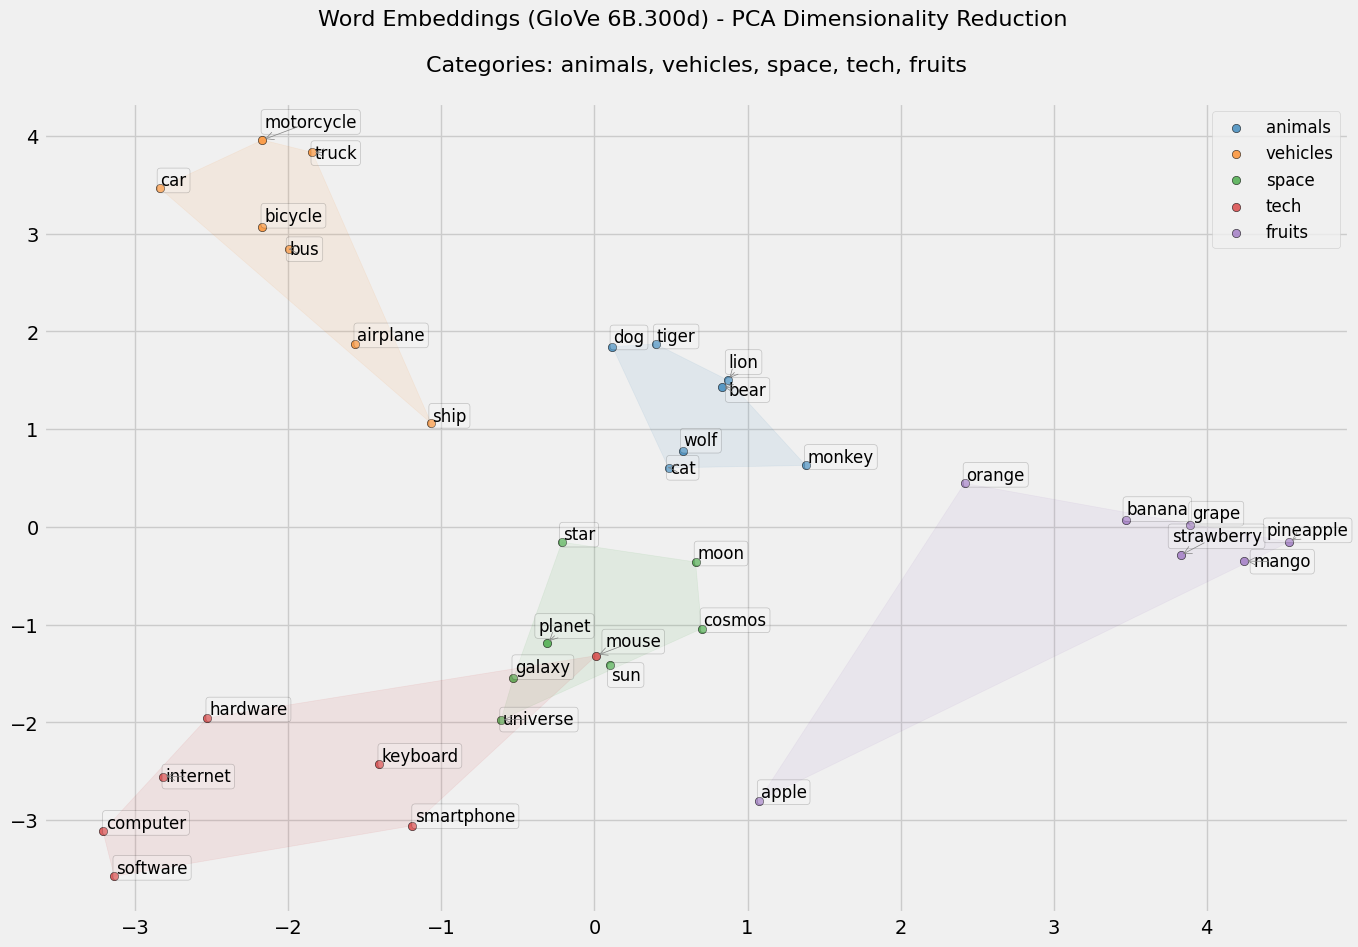

In [7]:
plot_embeddings_by_category(embeddings_dict, categories_dict, emb_dim, reducer=PCA)

### **t-SNE dimensionality reduction**

**Definition: t-SNE (t-Distributed Stochastic Neighbor Embedding)**

t-SNE is a **non-linear** dimensionality reduction technique that focuses on preserving the **local** neighborhoods of points. It converts high-dimensional distances into probabilities, then tries to keep similar points close in the 2D (or 3D) space while keeping dissimilar points apart. This method often uncovers clusters or local groupings more distinctly than linear methods.

**Key Points:**
- t-SNE is non-linear: it aims to preserve **local** relationships.
- It often highlights **clusters** effectively.
- The results can vary with different parameters (perplexity, learning rate, etc.) and random seeds.
- It can be more computationally expensive than PCA.

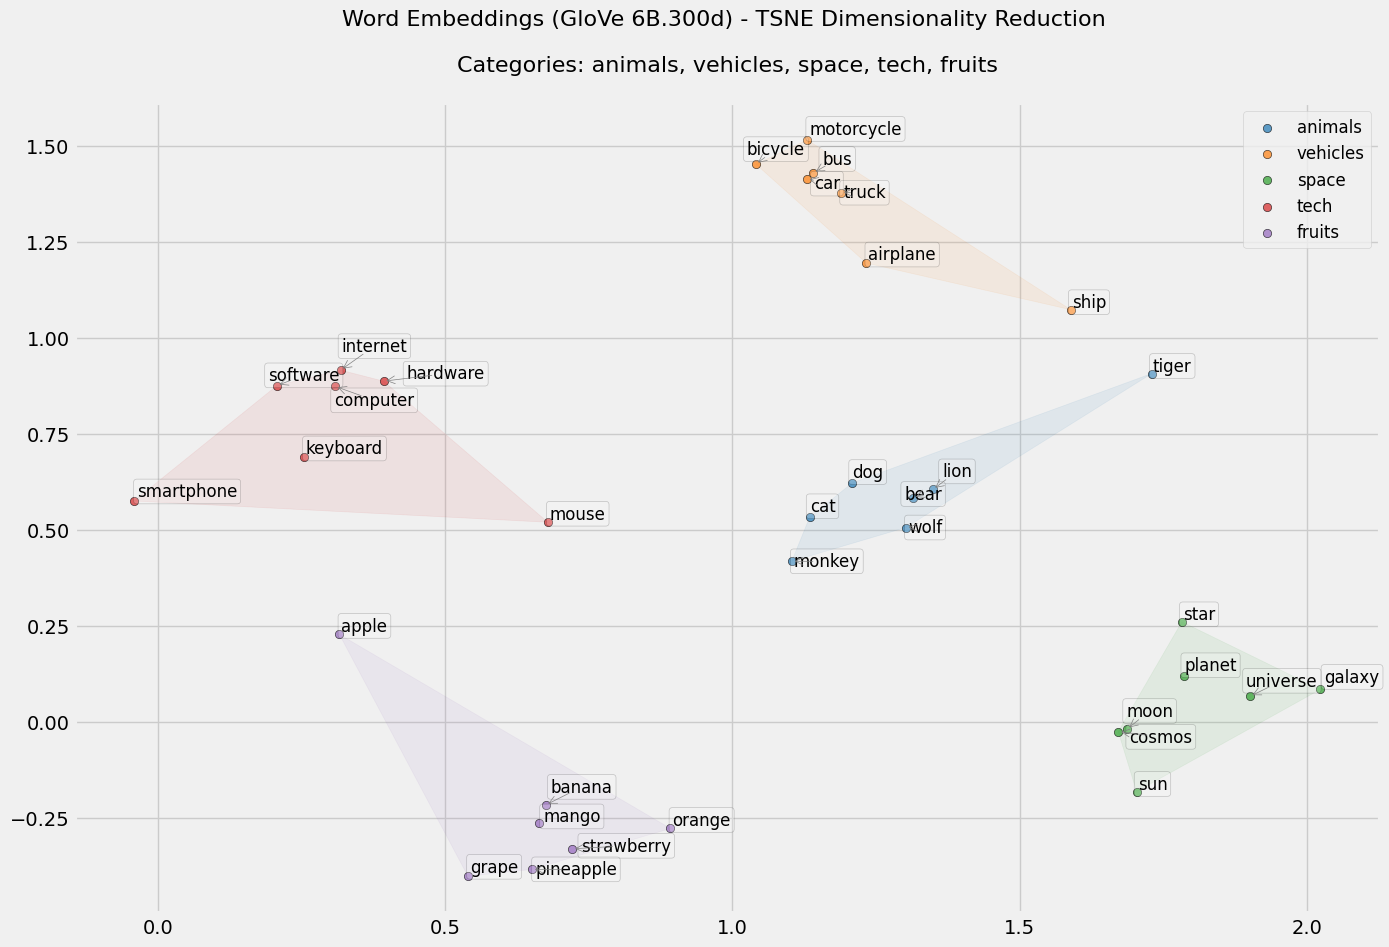

In [8]:
plot_embeddings_by_category(embeddings_dict, categories_dict, emb_dim, reducer=TSNE)

### **Comparison of PCA vs. t-SNE Plots**

After applying both PCA and t-SNE to the same set of word embeddings (GloVe 6B.300d), we can observe:

1. **Global vs. Local Structure**:
   - **PCA** tends to preserve global variance, so large-scale distances may be more meaningful. Words that are overall quite different might appear far apart, reflecting the global structure of the dataset.
   - **t-SNE** emphasizes local neighborhoods, making clusters of similar words more compact and visually distinct. Some points that appear close in t-SNE might be far in PCA if the global variance overshadowed local differences.

2. **Cluster Separation**:
   - In **t-SNE**, categories such as animals, vehicles, or tech often form tighter clusters.  
   - In **PCA**, clusters can still appear, but the boundaries may be less pronounced if the global variance is dominated by just a few large-scale features.

3. **Interpretability**:
   - **PCA** is linear, so each principal component can be interpreted as a direction of maximum variance.  
   - **t-SNE** is non-linear and does not provide easily interpretable axes, but it’s powerful for discovering local groupings.

4. **Consistency**:
   - **PCA** is deterministic: the same input yields the same result every time.  
   - **t-SNE** can vary with different random seeds, perplexities, or other hyperparameters.

In summary, **PCA** gives a broad overview of how embeddings vary in a global sense, while **t-SNE** often highlights local relationships and clusters more effectively. 


---

## **Anologies** 

**Word Analogies with Embeddings**

Word analogies provide a fascinating way to explore the semantic relationships captured by word embeddings. In this section, we use a simple vector arithmetic method to solve analogies of the form "word1 is to word2 as word3 is to ?". The process is as follows:

- **Vector Calculation:** We compute a target vector using the formula:  
  
  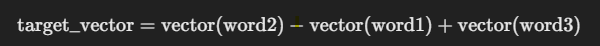

- **Similarity Search:** We then find the word whose embedding is most similar (using cosine similarity) to this target vector, excluding the words already used in the analogy.
- **Example:** For the analogy "man is to king as woman is to ?", the expected output is "queen", demonstrating that the embeddings capture the underlying gender relationship.

This method allows us to intuitively test and visualize the semantic structure learned by our embeddings.


### Examples

In [10]:
analogy_examples = [
    ("spain", "spanish", "france"),    # Expected result: french
    ("man", "king", "woman"),          # Expected result: queen
    ("paris", "france", "rome"),       # Expected result: italy or roman (ideally "italy")
    ("walking", "walked", "swimming"), # Expected result: swam
    ("big", "bigger", "small")         # Expected result: smaller 
]

In [11]:
for word1, word2, word3 in analogy_examples:
    analogy(word1, word2, word3, embeddings_dict)

Analogy: spain is to spanish as france is to french
Analogy: man is to king as woman is to queen
Analogy: paris is to france as rome is to italy
Analogy: walking is to walked as swimming is to swam
Analogy: big is to bigger as small is to larger


#### **Insights and Observations**

Nature of the Embeddings:  
    
- GloVe embeddings capture semantic relationships based on usage contexts, but they are not perfect. This means that while the vector arithmetic (word2 - word1 + word3) tends to produce reasonable results, the quality of the analogy depends on the quality of the model and the complexity of the linguistic relationships.

Method Limitations: 
    
- Vector arithmetic is a simple method that can capture linear relationships, but some semantic relationships may be more complex or non-linear, which can lead to unexpected results (such as "small" → "larger" instead of "smaller").

Variability and Linguistic Ambiguity:
    
- Some analogies may have multiple reasonable answers or depend on context. For example, in "paris is to france as rome is to ?", although "italy" is expected, the model might sometimes return a related but different term.


Overall, the output obtained is consistent with what one would expect from an embeddings model. It represents a useful approximation for understanding how semantic relationships are captured, while acknowledging that the method has its inherent limitations.


#### **Plot Analogies**

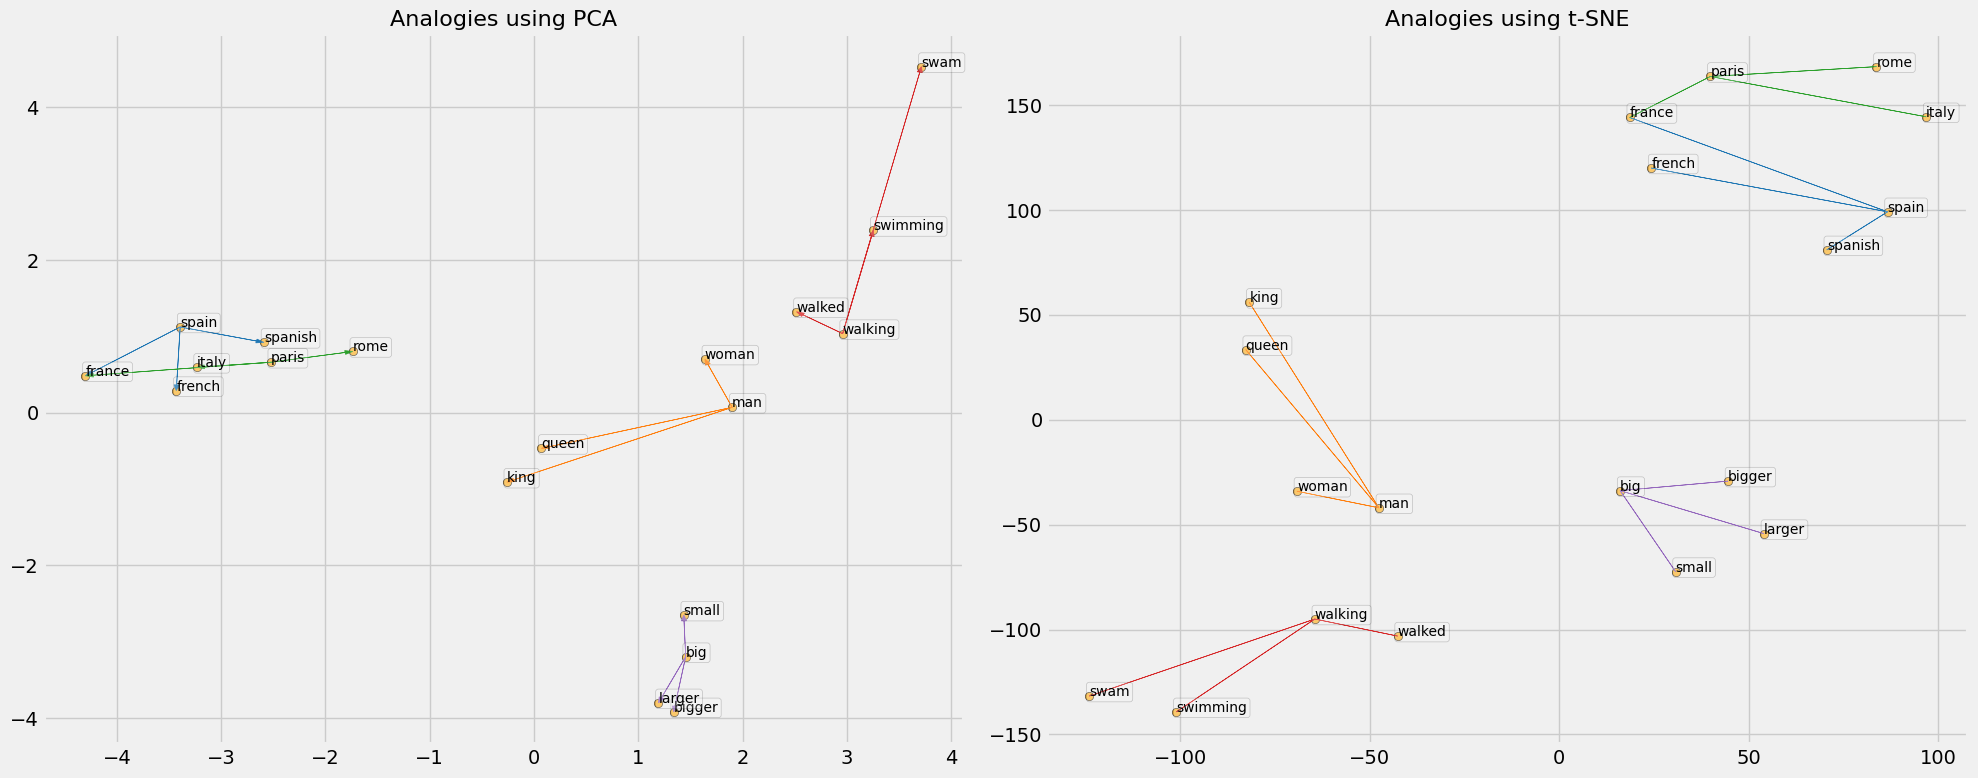

In [12]:
compare_analogy_reducers(analogy_examples, embeddings_dict, emb_dim=300, random_state=42, figsize=(20,8))

---

## **Similarity between words**

### Examples

In [13]:
# List of words to query for the most similar terms.
query_words = ['spain', 'apple', 'science', 'twitter', 'big']

In [14]:
for word in query_words:
    print(f"\nMost similar words to '{word}':")
    similar_words = find_most_similar(word, embeddings_dict, top_n=5)
    # Iterate over the similar words, printing each with its cosine similarity.
    for i, (w, sim) in enumerate(similar_words, 1):
        print(f'{i} --> {w} (similarity: {sim:.4f})')


Most similar words to 'spain':
1 --> spanish (similarity: 0.7019)
2 --> portugal (similarity: 0.6838)
3 --> madrid (similarity: 0.6208)
4 --> morocco (similarity: 0.5985)
5 --> argentina (similarity: 0.5971)

Most similar words to 'apple':
1 --> iphone (similarity: 0.5987)
2 --> macintosh (similarity: 0.5836)
3 --> ipod (similarity: 0.5761)
4 --> microsoft (similarity: 0.5664)
5 --> ipad (similarity: 0.5628)

Most similar words to 'science':
1 --> sciences (similarity: 0.6844)
2 --> physics (similarity: 0.6518)
3 --> scientific (similarity: 0.6487)
4 --> biology (similarity: 0.6283)
5 --> mathematics (similarity: 0.6216)

Most similar words to 'twitter':
1 --> facebook (similarity: 0.8350)
2 --> myspace (similarity: 0.7157)
3 --> youtube (similarity: 0.7003)
4 --> tweets (similarity: 0.6614)
5 --> blog (similarity: 0.6583)

Most similar words to 'big':
1 --> bigger (similarity: 0.6961)
2 --> huge (similarity: 0.6952)
3 --> biggest (similarity: 0.6498)
4 --> like (similarity: 0.6217)
5

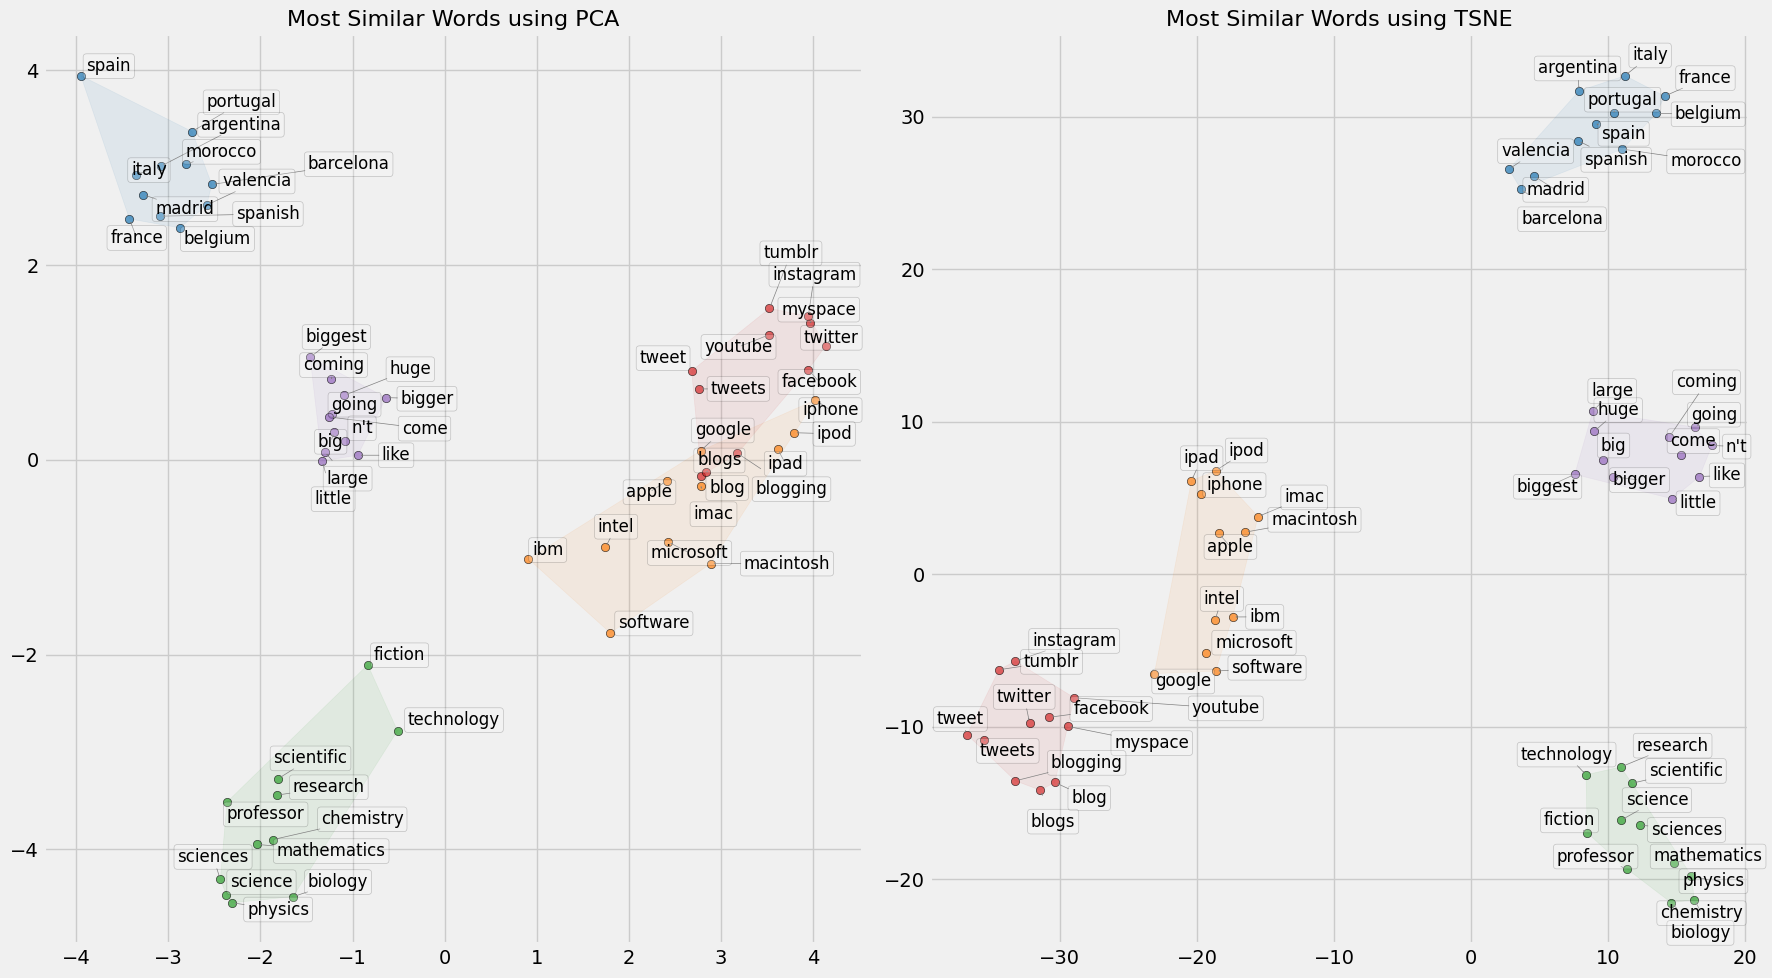

In [15]:
compare_most_similar_queries(query_words, embeddings_dict, top_n=10, random_state=42, figsize=(18,10))

**Reflections on the Results:**

1. **Word Clusters and Semantic Proximity:**  
   The plots show that words semantically close to each query term (e.g., "spain," "apple," "science," "twitter," "big") tend to cluster in the 2D projections (PCA or t-SNE). This indicates that the embeddings capture context-based similarities reasonably well (e.g., "spain" → "spanish," "argentina," "morocco"; "twitter" → "facebook," "myspace," etc.).

2. **Differences Between PCA and t-SNE:**  
   - **PCA** often preserves more “global” variance, which can spread out the points and sometimes make smaller clusters less distinct.  
   - **t-SNE** emphasizes local neighborhoods, often producing tighter clusters for related terms but can distort global distances.

3. **Observations from the Similar Words Lists:**  
   - **“spain”** linking to “spanish,” “portugal,” and “argentina” makes sense geographically and linguistically.  
   - **“apple”** connecting to “iphone,” “macintosh,” and “ipod” reflects the brand ecosystem.  
   - **“science”** linking to “physics,” “biology,” and “mathematics” is coherent with academic and research contexts.  
   - **“twitter”** being close to “facebook,” “myspace,” “youtube” indicates social media adjacency.  
   - **“big”** linking to “bigger,” “huge,” and “biggest” highlights the linear relationship capturing size adjectives.

Overall, the combination of numeric results (top_n most similar words) and graphical displays (2D scatter plots) provides both **quantitative** and **qualitative** insights into how these embeddings represent semantic relationships.